# Kernel Density Estimation

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.neighbors import KernelDensity

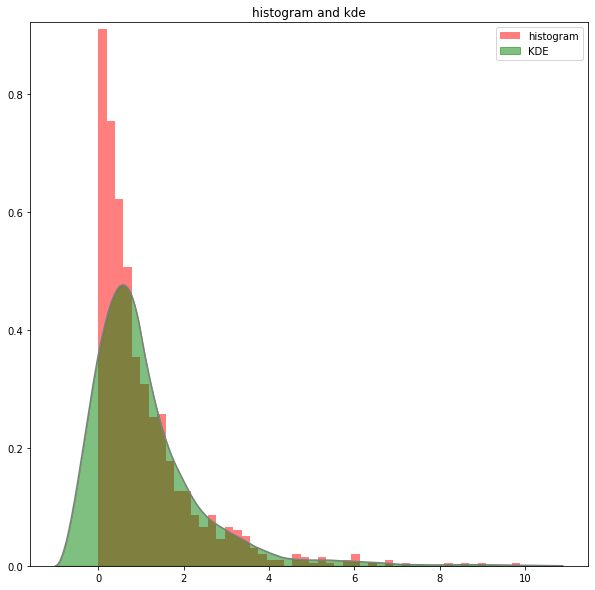

In [2]:
# * 探索代码
import numpy as np
from scipy.stats import genpareto
c = 0.1
x_train = genpareto.rvs(c, size=1000)
# x_train = np.hstack((np.random.normal(2, 1.66, 200), np.random.normal(8, 2.33, 200)))
 
bandwidth = 1.0
 
model = KernelDensity(bandwidth=bandwidth, kernel='epanechnikov')
model.fit(x_train[:, np.newaxis])
x_range = np.linspace(x_train.min() - 1, x_train.max() + 1, 500)
x_log_prob = model.score_samples(x_range[:, np.newaxis])
x_prob = np.exp(x_log_prob)

plt.figure(figsize=(10, 10))
r = plt.hist(
    x=x_train,
    bins=50,
    density=True,
    histtype='stepfilled',
    color='red',
    alpha=0.5,
    label='histogram',
)
plt.fill_between(
    x=x_range,
    y1=x_prob,
    y2=0,
    color='green',
    alpha=0.5,
    label='KDE',
)
plt.plot(x_range, x_prob, color='gray')
# plt.vlines(x=2, ymin=0, ymax=r[0].max() + 0.01, color='k', linestyle='--', alpha=0.7)
# plt.vlines(x=8, ymin=0, ymax=r[0].max() + 0.01, color='k', linestyle='--', alpha=0.7)
plt.ylim(0, r[0].max() + 0.011)
plt.legend(loc='upper right')
plt.title('histogram and kde')
plt.show()

使用4个周期预热detector、使用1个周期预热distribution

In [17]:
# Unit Test Apple
nx_prob = x_prob / x_prob.sum()
idx = pd.Series(nx_prob.cumsum() - (1-0.01)).abs().argmin()
x_range[idx]

6.093912511164726

ARIMA，KDE

In [30]:
# Functional Test
from tqdm import tqdm
from detector.online_arima import OnlineARIMA
from distribution.kde import KDE
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
# series.plot.line()

# 预热detector
oarima = OnlineARIMA(series[0:4*1440])

# 预热distribution
Xhat = []
for i in tqdm(range(3 * 1440, 4 * 1440)):
    xhat = oarima.update(series[i])
    Xhat.append(xhat)
kde = KDE(Xhat)

# 在线检测
Xhat = []
Yhat = []
for i in tqdm(range(4 * 1440, 8 * 1440)):
    xhat = oarima.update(series[i])
    Xhat.append(xhat)
    yhat = kde.step(xhat)
    Yhat.append(yhat)
# pd.Series(Xhat).plot.line()

100%|██████████| 5760/5760 [02:20<00:00, 41.14it/s]


使用KDE分布可以抑制连续告警

<AxesSubplot:>

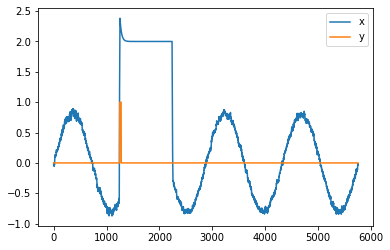

In [34]:
pd.DataFrame({'x': Xhat, 'y': Yhat}).plot.line()

STL，KDE

In [7]:
# Functional Test
from tqdm import tqdm
from detector.online_stl import OnlineSTL
from distribution.kde import KDE
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
# series.plot.line()

# 预热detector
stl = OnlineSTL(series[0:4*1440])

# 预热distribution
Xhat = []
for i in tqdm(range(3 * 1440, 4 * 1440)):
    _, _, xhat = stl.update(series[i])
    Xhat.append(xhat)
kde = KDE(Xhat, theta=0.05)

# 在线检测
Xhat = []
Yhat = []
for i in tqdm(range(4 * 1440, 8 * 1440)):
    _, _, xhat = stl.update(series[i])
    Xhat.append(xhat)
    yhat = kde.step(xhat)
    Yhat.append(yhat)
# pd.Series(Xhat).plot.line()

  2%|▏         | 105/5760 [00:04<04:05, 23.08it/s]


KeyboardInterrupt: 

<AxesSubplot:>

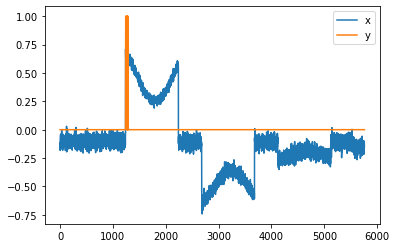

In [47]:
pd.DataFrame({'x': Xhat, 'y': Yhat}).plot.line()

SVR，KDE

In [8]:
# Functional Test
from tqdm import tqdm
from detector.online_svr import OnlineSVR
from distribution.kde import KDE
# 生成测试数据
x=np.linspace(0,8*2*np.pi,8*1440)
y=0.8 * np.sin(x) + 0.10 * np.random.randn(8 * 1440)
series = pd.Series(y)
# 注入异常
for i in range(7000, 8000):
    y[i] = 2.0
# series.plot.line()

# 预热detector
svr = OnlineSVR(series[0:4*1440])

# 预热distribution
Xhat = []
for i in tqdm(range(3 * 1440, 4 * 1440)):
    xhat = svr.update(series[i])
    Xhat.append(xhat)
kde = KDE(Xhat, theta=0.05)

# 在线检测
Xhat = []
Yhat = []
for i in tqdm(range(4 * 1440, 8 * 1440)):
    xhat = svr.update(series[i])
    Xhat.append(xhat)
    yhat = kde.step(xhat)
    Yhat.append(yhat)
# pd.Series(Xhat).plot.line()

  0%|          | 0/1410 [00:00<?, ?it/s]d:\ensemble2\detector\online_svr.py:90: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  minValues = np.array([Lc1, Lc2, Ls[minLsIndex], Le[minLeIndex], Lr[minLrIndex]])
100%|██████████| 5760/5760 [02:47<00:00, 34.46it/s]


<AxesSubplot:>

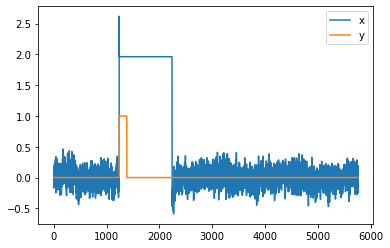

In [9]:
pd.DataFrame({'x': Xhat, 'y': Yhat}).plot.line()

# Code Repo

In [4]:
class KDE:
    '''
        @param m period
    '''
    def __init__(self, x_train, m=1440, theta=0.01, bandwidth=1, kernel='epanechnikov'):
        self.theta=theta
        self.window = np.array(x_train.copy()[-m:])
        self.model = KernelDensity(bandwidth=bandwidth, kernel=kernel)
    
    '''
        @return True/False if residual of current step is judged an outlier.
    '''
    def step(self, residual):
        def update_array(array, update):
            updated = np.roll(array, -1)
            updated[-1] = update
            return updated
        self.window = update_array(self.window, residual)
        self.model.fit(self.window[:, np.newaxis])
        x_range = np.linspace(self.window.min() - 1, self.window.max() + 1, 500)
        x_log_prob = self.model.score_samples(x_range[:, np.newaxis])
        x_prob = np.exp(x_log_prob)
        nx_prob = x_prob / x_prob.sum()
        idx = pd.Series(nx_prob.cumsum() - (1-self.theta)).abs().argmin()
        # cache plot parameters.
        self.x_range = x_range
        self.x_prob = x_prob
        if residual > x_range[idx]:
            return 1
        return 0
    
    def plot(self):
        plt.figure(figsize=(10, 10))
        r = plt.hist(
            x=self.window,
            bins=50,
            density=True,
            histtype='stepfilled',
            color='red',
            alpha=0.5,
            label='histogram',
        )
        plt.fill_between(
            x=self.x_range,
            y1=self.x_prob,
            y2=0,
            color='green',
            alpha=0.5,
            label='KDE',
        )
        plt.plot(self.x_range, self.x_prob, color='gray')
        # plt.vlines(x=2, ymin=0, ymax=r[0].max() + 0.01, color='k', linestyle='--', alpha=0.7)
        # plt.vlines(x=8, ymin=0, ymax=r[0].max() + 0.01, color='k', linestyle='--', alpha=0.7)
        plt.ylim(0, r[0].max() + 0.011)
        plt.legend(loc='upper right')
        plt.title('histogram and kde')
        plt.show()